In [491]:
import pandas as pd 
import numpy as np 
import networkx as nx
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

def cal_info(random_graph, sub_df):
    degree_dict = dict(random_graph.degree())
    degree_mean = sub_df.node_name.map(degree_dict).values.mean()
    cancer_node_name = sub_df.node_name[sub_df.is_cancer_protein]
    cancer_sub_graph = random_graph.subgraph(cancer_node_name)
    edges_df = pd.DataFrame(list(cancer_sub_graph.edges), columns=["src", "dst"])
    
    # 對應四種情況四種情況
    src_in_tsg = edges_df.src.isin(sub_df.node_name[sub_df.is_TSG])
    dst_in_tsg = edges_df.dst.isin(sub_df.node_name[sub_df.is_TSG])
    src_in_oncogene = edges_df.src.isin(sub_df.node_name[sub_df.is_oncogene])
    dst_in_oncogene = edges_df.dst.isin(sub_df.node_name[sub_df.is_oncogene])

    # TSG-TSG, oncogene-oncogene, TSG-oncogene or oncogene-TSG
    n_tsg_edges = (src_in_tsg & dst_in_tsg).sum()
    n_oncogene_edges = (src_in_oncogene & dst_in_oncogene).sum()
    n_tsg_oncogene_edges = ((src_in_tsg & dst_in_oncogene) | (src_in_oncogene & dst_in_tsg)).sum()
    return [degree_mean, nx.density(cancer_sub_graph), n_tsg_edges, n_oncogene_edges, n_tsg_oncogene_edges]

def result_df(n_permutation):
    return pd.DataFrame(columns=["degree_mean", "cancer_density", "n_tsg_edges", "n_oncogene_edges", "n_tsg_oncogene_edges"], index=range(n_permutation))

In [434]:
edges_df = pd.read_csv("data/edges.csv", index_col=0)
node_df = pd.read_csv("data/nodes.csv")
base_graph = nx.Graph()
base_graph.add_edges_from(zip(edges_df.src, edges_df.dst))
n_nodes = len(base_graph.nodes)
n_edges = len(base_graph.edges)

cancer_sub_df = node_df[node_df.is_cancer_protein]
n_cancer_gene = len(cancer_sub_df)
n_permutation = 1000
node_dict = node_df.node_name.to_dict()
real_df = result_df(1)
real_df.iloc[0, :] = cal_info(base_graph, cancer_sub_df)
real_df

,degree_mean,cancer_density,n_tsg_edges,n_oncogene_edges,n_tsg_oncogene_edges
0,184.954738,0.038101,2284,2955,4331


In [508]:
real_df.to_csv("output/real_df.csv")

In [492]:
# 1
result_edges_num_preserving = result_df(n_permutation)
for i in tqdm(range(n_permutation)):
    random_graph = nx.gnm_random_graph(n_nodes, n_edges)
    random_graph = nx.relabel_nodes(random_graph, node_dict)
    result_edges_num_preserving.iloc[i, :] = cal_info(random_graph, cancer_sub_df)
result_edges_num_preserving.to_csv("output/result_edges_num_preserving.csv")
result_edges_num_preserving

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [36:11<00:00,  2.17s/it]


,degree_mean,cancer_density,n_tsg_edges,n_oncogene_edges,n_tsg_oncogene_edges
0,78.991513,0.004468,209,200,445
1,78.575672,0.004303,206,212,381
2,78.78925,0.004139,191,205,366
3,78.794908,0.004251,211,198,389
4,79.082037,0.004095,183,190,410
...,...,...,...,...,...
995,78.722772,0.004392,207,210,393
996,78.236209,0.004215,199,195,377
997,78.745403,0.004107,205,195,377
998,78.719943,0.004163,194,198,405


In [493]:
# 2
result_degree_preserving = result_df(n_permutation)
for i in tqdm(range(n_permutation)):
    random_graph = nx.double_edge_swap(base_graph, nswap=n_edges//2, max_tries=n_edges)
    result_degree_preserving.iloc[i, :] = cal_info(random_graph, cancer_sub_df)
result_degree_preserving.to_csv("output/result_degree_preserving.csv")
result_degree_preserving

100%|██████████| 1000/1000 [1:38:55<00:00,  5.94s/it]


,degree_mean,cancer_density,n_tsg_edges,n_oncogene_edges,n_tsg_oncogene_edges
0,184.954738,0.028301,1603,1986,3175
1,184.954738,0.024402,1341,1619,2761
2,184.954738,0.023164,1208,1549,2627
3,184.954738,0.022927,1163,1480,2553
4,184.954738,0.022931,1169,1488,2609
...,...,...,...,...,...
995,184.954738,0.022735,1183,1468,2525
996,184.954738,0.022611,1138,1459,2512
997,184.954738,0.022779,1160,1504,2482
998,184.954738,0.022507,1119,1456,2502


In [494]:
# 3
result_label_swap = result_df(n_permutation)
for i in tqdm(range(n_permutation)):
    random_sub_df = cancer_sub_df.copy()
    random_sub_df.node_name = node_df.sample(n_cancer_gene).node_name.values
    random_node_dict = dict(zip(node_df.node_name.values, random_sub_df.node_name))
    random_graph = nx.relabel_nodes(base_graph, random_node_dict)
    result_label_swap.iloc[i, :] = cal_info(base_graph, random_sub_df)
result_label_swap.to_csv("output/label_swap.csv")

100%|██████████| 1000/1000 [15:11<00:00,  1.10it/s]


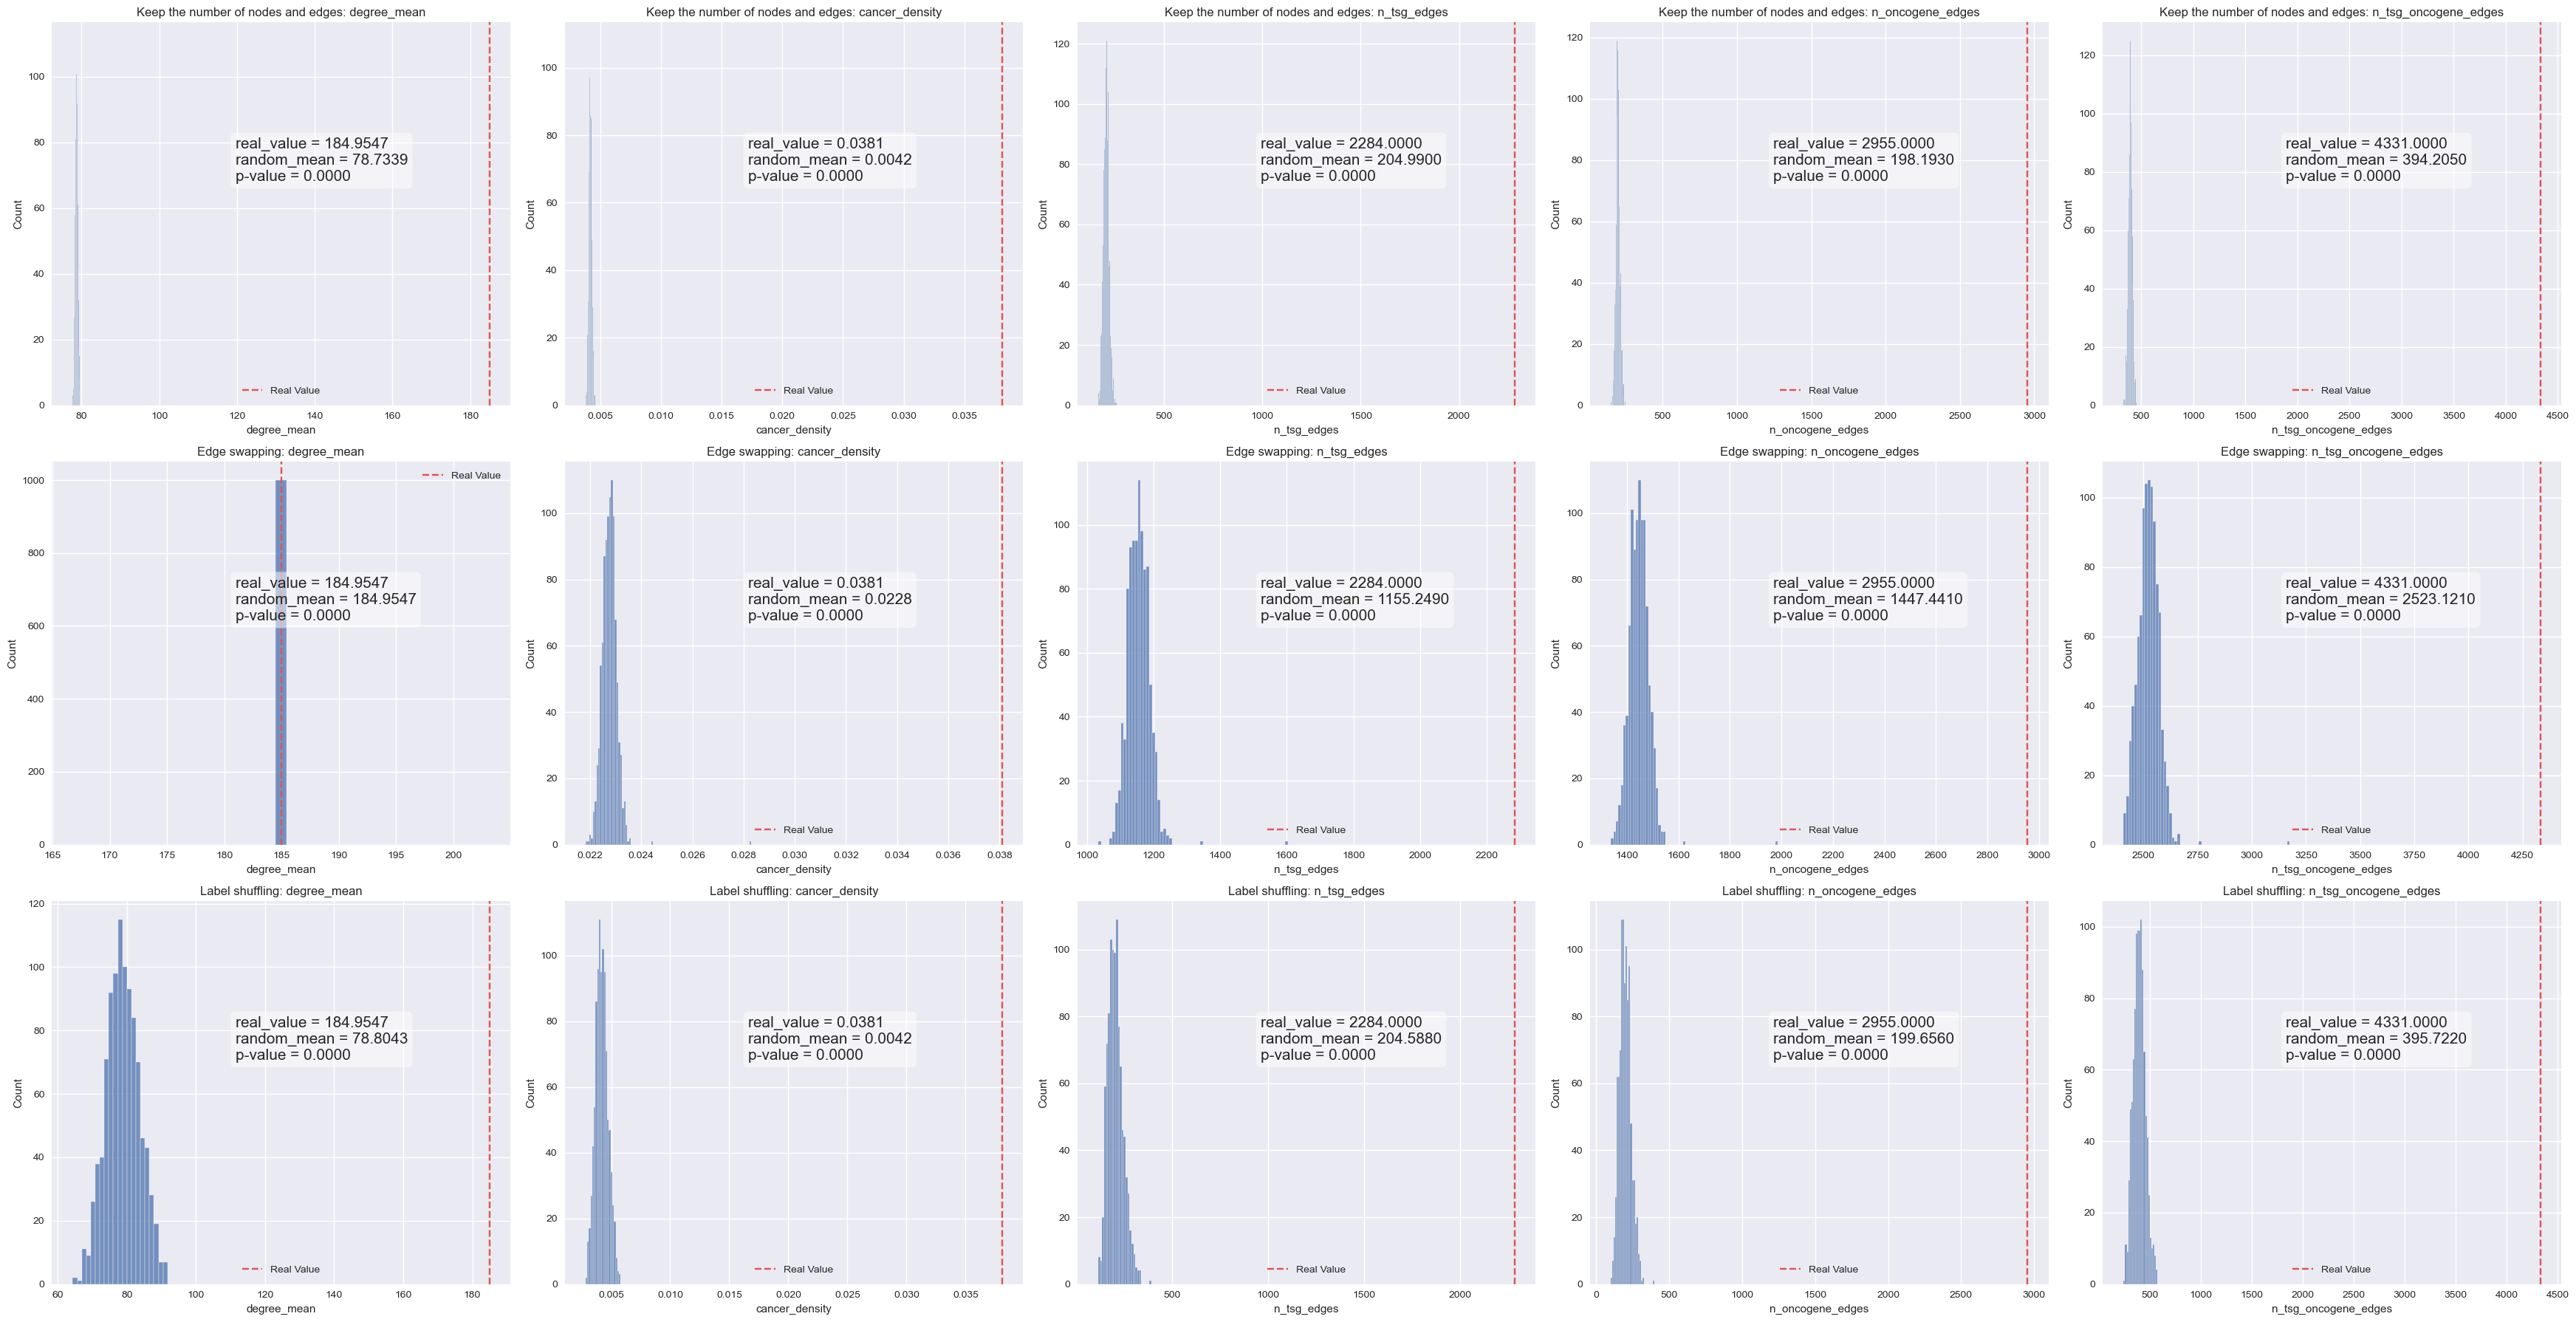

In [507]:
fig, axes = plt.subplots(3, 5, figsize=(35, 18))
model_description = ["Keep the number of nodes and edges", "Edge swapping", "Label shuffling"]
model_df_list = [result_edges_num_preserving, result_degree_preserving, result_label_swap]
# Iterate through models and columns
for i, random_df in enumerate(model_df_list):
    for j, col_name in enumerate(random_df.columns):
        # Plot in the corresponding subplot
        permutation_col = random_df.loc[:, col_name]
        real_value = real_df.loc[:, col_name].values
        if i == 1 and j == 0: # 特別處理全部值都相同的
            axes[i, j].set_xlim(real_value[0] - 20, real_value[0] + 20)
        pvalue = (permutation_col > real_value[0]).sum()
        sns.histplot(permutation_col, bins='auto', kde=False, ax=axes[i, j])
        axes[i, j].axvline(real_value[0], c="#dd5555", linestyle='--', label='Real Value')
        axes[i, j].set_title(f'{model_description[i]}: {col_name}')
        axes[i, j].text(0.4, 0.7, f"real_value = {real_value[0]:.4f}\nrandom_mean = {permutation_col.mean():.4f}\np-value = {pvalue:.4f}", transform=axes[i, j].transAxes, fontsize=15, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
        # Add legend
        axes[i, j].legend()
        
# Adjust layout
plt.tight_layout()

# Show the plots
filename = f"output/img/result1.png"
plt.savefig(filename, bbox_inches='tight', dpi=600)

In [ ]:
keep_the_number_of_nodes_and_edges_permutations
edge_swapping_result_permutations
label_shuffling_permutations